# Pré-processamento de Imagens Sentinel para o Protótipo NAIÁ

Este notebook realiza o pré-processamento das imagens Sentinel-1 (VV/VH) e Sentinel-2 (RGB+NIR) para Barão Geraldo, Campinas (SP), no contexto do Hackathon CopernicusLAC Panamá 2025 (Dia 1, 20:56, 29/07/2025, -03). O objetivo é:
1. Validar que as imagens cobrem a área de interesse definida em `data/area_prova_bbox.geojson` (bounding box: [-47.10, -22.85, -47.03, -22.78]).
2. Recortar as imagens pelos setores censitários urbanos (137 setores, filtrados por `SITUACAO = 'Urbana'` e `AREA_KM2 <= 1.0`) do arquivo `data/area_prova_barao.geojson`.

## Configuração
- **Ambiente**: `naia-env` (Python 3.12.7).
- **Repositório**: `/home/lorhan/git/CorpenicusHackthon/`.
- **Entradas**:
  - `data/sentinel1_unicamp.tiff` (Sentinel-1, VV/VH).
  - `data/sentinel2_unicamp.tiff` (Sentinel-2, RGB+NIR).
  - `data/area_prova_bbox.geojson` (bounding box da área).
  - `data/area_prova_barao.geojson` (137 setores censitários).
- **Saídas**:
  - `data/processed/s1_bbox_validation.png` e `data/processed/s2_bbox_validation.png` (validação da bounding box).
  - `data/processed/s1_sectors_validation.png` e `data/processed/s2_sectors_validation.png` (validação dos setores).
  - `data/processed/s1_setor_<CD_SETOR>.tiff` e `data/processed/s2_setor_<CD_SETOR>.tiff` (imagens recortadas).

## Pré-requisitos
1. Ative o ambiente: `source naia-env/bin/activate`.
2. Instale dependências:
   ```bash
   pip install geopandas rasterio matplotlib
   pip freeze > requirements.txt
   ```
3. Execute `ingest_sentinel.ipynb` para gerar os TIFFs.
4. Verifique a existência de `data/area_prova_bbox.geojson` e `data/area_prova_barao.geojson`.
5. Execute as células sequencialmente.

In [36]:
# Importações
import os
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import numpy as np
import glob

# Configurar diretórios
os.makedirs('data/processed', exist_ok=True)
print('✓ Diretório data/processed/ criado ou já existente')

# Definir caminhos
s1_path = 'data/sentinel1_unicamp.tiff'
s2_path = 'data/sentinel2_unicamp.tiff'
bbox_path = 'data/area_prova_bbox.geojson'
sectors_path = 'data/area_prova_barao.geojson'

# Verificar arquivos de entrada
print('\n--- Verificando arquivos de entrada ---')
files_to_check = [s1_path, s2_path, bbox_path, sectors_path]
for file_path in files_to_check:
    if os.path.exists(file_path):
        size_mb = os.path.getsize(file_path) / (1024 * 1024)
        print(f'✓ {file_path} ({size_mb:.1f} MB)')
    else:
        print(f'❌ {file_path} não encontrado')

✓ Diretório data/processed/ criado ou já existente

--- Verificando arquivos de entrada ---
✓ data/sentinel1_unicamp.tiff (0.4 MB)
✓ data/sentinel2_unicamp.tiff (0.7 MB)
✓ data/area_prova_bbox.geojson (0.0 MB)
✓ data/area_prova_barao.geojson (0.3 MB)


## 1. Validação da Bounding Box

Carregamos `data/area_prova_bbox.geojson` e verificamos se as imagens Sentinel-1 e Sentinel-2 cobrem a área de Barão Geraldo ([-47.10, -22.85, -47.03, -22.78]).

✓ Bounding box carregada: 1 polígono(s)
  CRS original: EPSG:4326
  Bounds: minx=-47.1000, miny=-22.8500, maxx=-47.0300, maxy=-22.7800

--- Validando Sentinel-1 ---
  CRS da imagem: EPSG:4326
  Bounds da imagem: BoundingBox(left=-47.1, bottom=-22.85, right=-47.03, top=-22.78)
  Dimensões: 512 x 512
  Bandas: 2
  Bounds da bbox reprojetada: [-47.1  -22.85 -47.03 -22.78]
  Visualizando Sentinel-1 (VV) em escala log


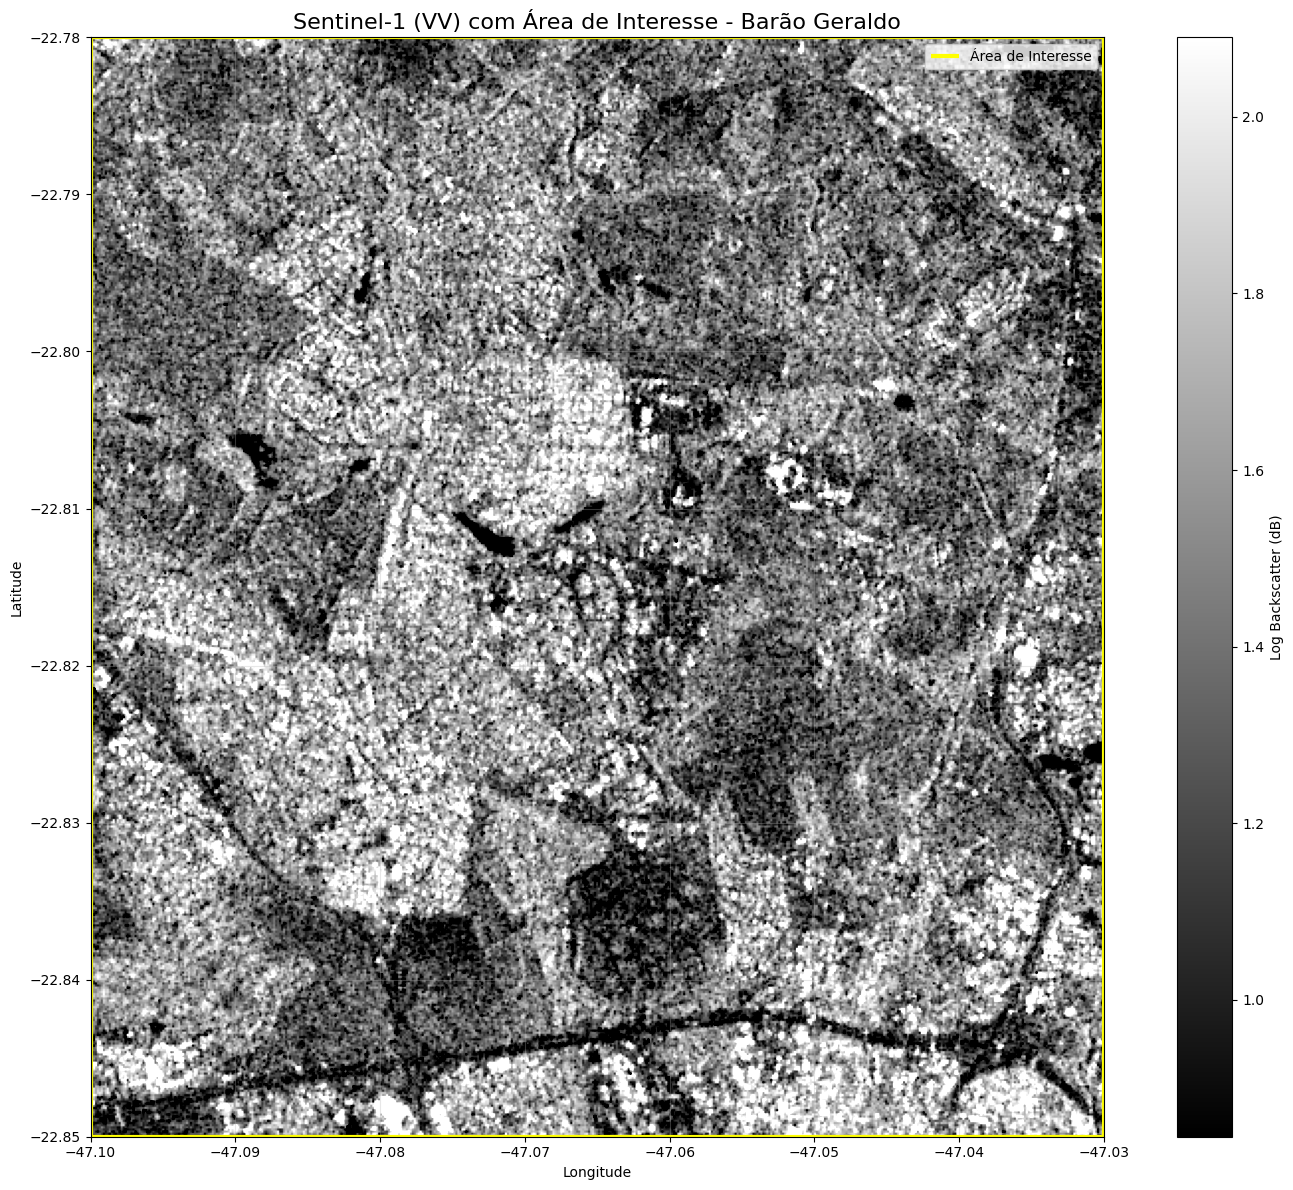

✓ Visualização salva em data/processed/s1_bbox_validation.png

--- Validando Sentinel-2 ---
  CRS da imagem: EPSG:4326
  Bounds da imagem: BoundingBox(left=-47.1, bottom=-22.85, right=-47.03, top=-22.78)
  Dimensões: 512 x 512
  Bandas: 4
  Bounds da bbox reprojetada: [-47.1  -22.85 -47.03 -22.78]
  Visualizando Sentinel-2 como RGB


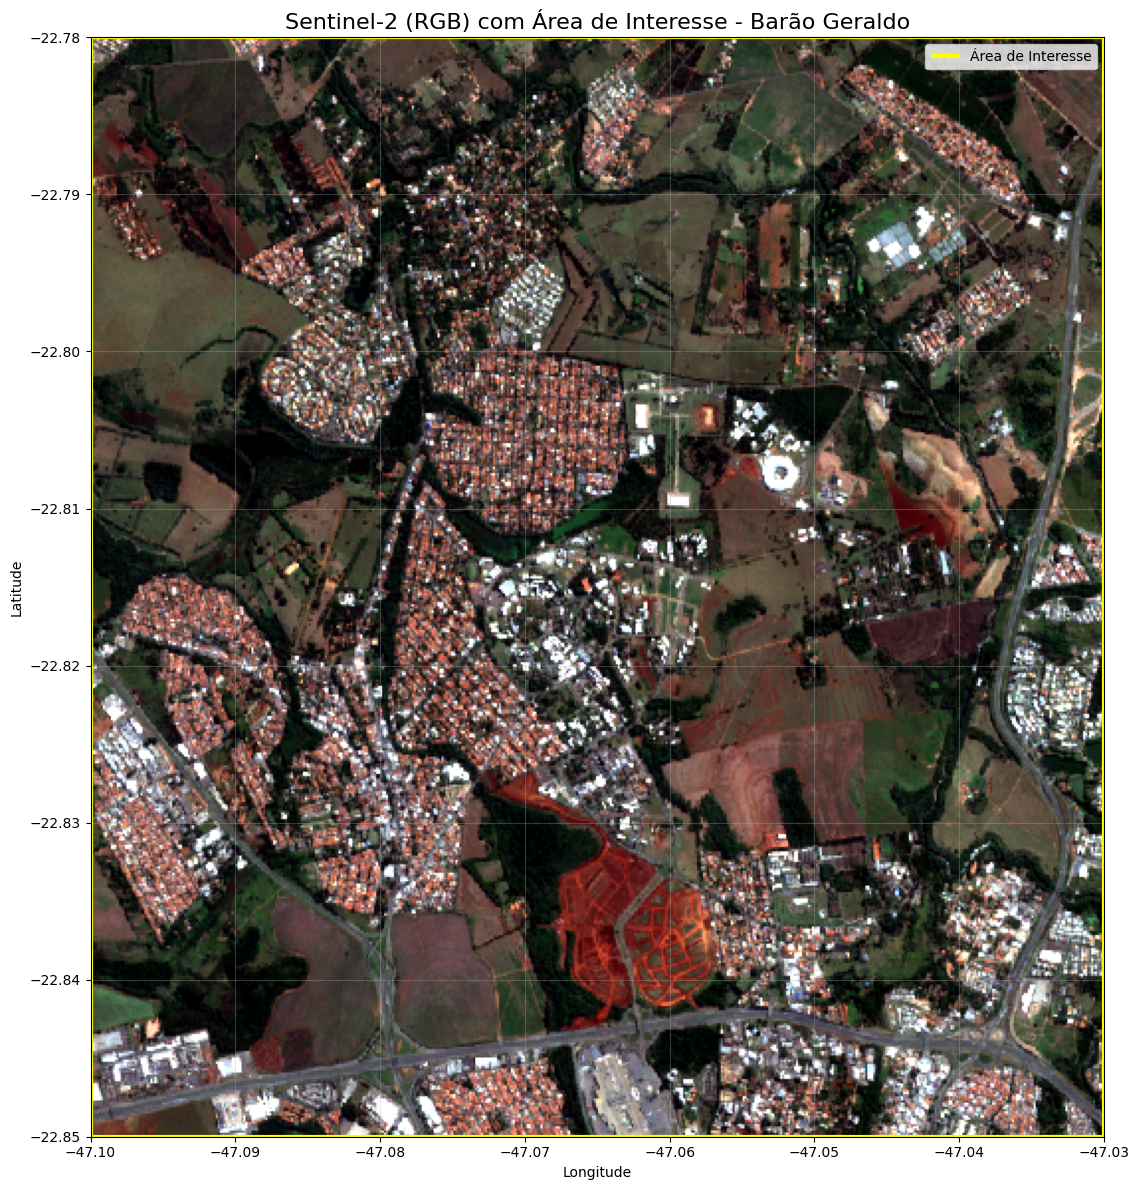

✓ Visualização salva em data/processed/s2_bbox_validation.png

✅ Resultados da validação:
  Sentinel-1: ✓
  Sentinel-2: ✓


In [37]:
try:
    bbox_gdf = gpd.read_file(bbox_path)
    print(f'✓ Bounding box carregada: {len(bbox_gdf)} polígono(s)')
    print(f'  CRS original: {bbox_gdf.crs}')
    # Garantir WGS84 (EPSG:4326)
    if bbox_gdf.crs != 'EPSG:4326':
        bbox_gdf = bbox_gdf.to_crs('EPSG:4326')
        print('✓ Bounding box convertida para EPSG:4326 (WGS84)')
    # Mostrar bounds para debug
    bounds = bbox_gdf.bounds
    print(f'  Bounds: minx={bounds.minx.iloc[0]:.4f}, miny={bounds.miny.iloc[0]:.4f}, '
          f'maxx={bounds.maxx.iloc[0]:.4f}, maxy={bounds.maxy.iloc[0]:.4f}')
except Exception as e:
    print(f'❌ Erro ao carregar {bbox_path}: {e}')
    bbox_gdf = None

def validate_bbox_coverage(tiff_path, gdf, title, output_file):
    """Visualiza a imagem com a bounding box sobreposta."""
    if not os.path.exists(tiff_path):
        print(f'❌ Arquivo {tiff_path} não encontrado')
        return False
    try:
        with rasterio.open(tiff_path) as src:
            print(f'  CRS da imagem: {src.crs}')
            print(f'  Bounds da imagem: {src.bounds}')
            print(f'  Dimensões: {src.width} x {src.height}')
            print(f'  Bandas: {src.count}')
            # Reprojetar GeoDataFrame para o CRS da imagem
            gdf_reproj = gdf.to_crs(src.crs)
            print(f'  Bounds da bbox reprojetada: {gdf_reproj.bounds.iloc[0].values}')
            # Ler imagem
            image = src.read()
            # Preparar visualização
            fig, ax = plt.subplots(figsize=(15, 12))
            # Mostrar imagem baseada no tipo
            if image.shape[0] >= 3:  # Sentinel-2 (RGB+NIR)
                rgb = image[[0, 1, 2]]  # R, G, B
                rgb_norm = np.zeros_like(rgb, dtype=np.float32)
                for i in range(3):
                    band = rgb[i]
                    p2, p98 = np.percentile(band[band > 0], [2, 98])
                    rgb_norm[i] = np.clip((band - p2) / (p98 - p2), 0, 1)
                img_display = rgb_norm.transpose(1, 2, 0)
                ax.imshow(img_display, extent=[src.bounds.left, src.bounds.right, 
                                              src.bounds.bottom, src.bounds.top])
                print('  Visualizando Sentinel-2 como RGB')
            else:  # Sentinel-1 (VV/VH)
                band = image[0]  # VV
                band_log = np.log10(band + 1e-10)
                vmin, vmax = np.percentile(band_log[band_log > -10], [5, 95])
                im = ax.imshow(band_log, cmap='gray', vmin=vmin, vmax=vmax,
                              extent=[src.bounds.left, src.bounds.right, 
                                      src.bounds.bottom, src.bounds.top])
                plt.colorbar(im, ax=ax, label='Log Backscatter (dB)')
                print('  Visualizando Sentinel-1 (VV) em escala log')
            # Plotar bounding box
            gdf_reproj.boundary.plot(ax=ax, color='yellow', linewidth=3, label='Área de Interesse')
            ax.set_title(title, fontsize=16)
            ax.set_xlabel('Longitude' if src.crs.to_string() == 'EPSG:4326' else 'X (m)')
            ax.set_ylabel('Latitude' if src.crs.to_string() == 'EPSG:4326' else 'Y (m)')
            ax.legend()
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            plt.show()
            print(f'✓ Visualização salva em {output_file}')
            return True
    except Exception as e:
        print(f'❌ Erro na validação da bounding box para {tiff_path}: {e}')
        import traceback
        traceback.print_exc()
        return False

if bbox_gdf is not None:
    print('\n--- Validando Sentinel-1 ---')
    s1_ok = validate_bbox_coverage(s1_path, bbox_gdf, 
                                  'Sentinel-1 (VV) com Área de Interesse - Barão Geraldo', 
                                  'data/processed/s1_bbox_validation.png')
    print('\n--- Validando Sentinel-2 ---')
    s2_ok = validate_bbox_coverage(s2_path, bbox_gdf, 
                                  'Sentinel-2 (RGB) com Área de Interesse - Barão Geraldo', 
                                  'data/processed/s2_bbox_validation.png')
    print(f'\n✅ Resultados da validação:')
    print(f'  Sentinel-1: {"✓" if s1_ok else "❌"}')
    print(f'  Sentinel-2: {"✓" if s2_ok else "❌"}')
else:
    print('❌ Não foi possível carregar a bounding box para validação')

## 2. Carregamento e Filtro dos Setores Censitários

Carregamos `data/area_prova_barao.geojson`, filtramos os setores censitários urbanos com área ≤ 1.0 km², e garantimos que apenas setores dentro da bounding box sejam processados.

In [38]:
try:
    sectors_gdf = gpd.read_file(sectors_path)
    print(f'✓ GeoJSON de setores carregado: {len(sectors_gdf)} setores censitários')
    print(f'  Colunas disponíveis: {list(sectors_gdf.columns)}')
    # Verificar se CD_SETOR existe
    if 'CD_SETOR' not in sectors_gdf.columns:
        raise ValueError('Coluna CD_SETOR não encontrada no GeoJSON')
    # Garantir CRS EPSG:4326
    if sectors_gdf.crs != 'EPSG:4326':
        sectors_gdf = sectors_gdf.to_crs('EPSG:4326')
        print('✓ Setores convertidos para EPSG:4326 (WGS84)')
    # Filtrar setores urbanos com área <= 1.0 km²
    sectors_gdf_urban = sectors_gdf[(sectors_gdf['SITUACAO'] == 'Urbana') & (sectors_gdf['AREA_KM2'] <= 1.0)]
    print(f'✓ Setores filtrados: {len(sectors_gdf_urban)} setores urbanos com área ≤ 1.0 km²')
    if len(sectors_gdf_urban) == 0:
        raise ValueError('Nenhum setor urbano encontrado após filtro')
    # Filtrar setores dentro da bounding box
    if bbox_gdf is not None:
        bbox_geometry = bbox_gdf.geometry.iloc[0]
        sectors_gdf_urban = sectors_gdf_urban[sectors_gdf_urban.geometry.intersects(bbox_geometry)]
        print(f'✓ Setores filtrados pela bounding box: {len(sectors_gdf_urban)} setores')
    # Validar geometrias
    sectors_gdf_urban['geometry'] = sectors_gdf_urban.geometry.buffer(0)  # Corrige geometrias inválidas
    print('✓ Geometrias validadas')
except Exception as e:
    print(f'❌ Erro ao carregar ou processar {sectors_path}: {e}')
    sectors_gdf_urban = None

✓ GeoJSON de setores carregado: 137 setores censitários
  Colunas disponíveis: ['CD_SETOR', 'SITUACAO', 'CD_SIT', 'CD_TIPO', 'AREA_KM2', 'CD_REGIAO', 'NM_REGIAO', 'CD_UF', 'NM_UF', 'CD_MUN', 'NM_MUN', 'CD_DIST', 'NM_DIST', 'CD_SUBDIST', 'NM_SUBDIST', 'CD_BAIRRO', 'NM_BAIRRO', 'CD_NU', 'NM_NU', 'CD_FCU', 'NM_FCU', 'CD_AGLOM', 'NM_AGLOM', 'CD_RGINT', 'NM_RGINT', 'CD_RGI', 'NM_RGI', 'CD_CONCURB', 'NM_CONCURB', 'geometry']
✓ Setores filtrados: 128 setores urbanos com área ≤ 1.0 km²
✓ Setores filtrados pela bounding box: 88 setores
✓ Geometrias validadas


## 3. Validação dos Setores Censitários

Visualizamos os setores censitários urbanos sobre as imagens Sentinel-1 e Sentinel-2.


--- Validando setores Sentinel-1 ---
  CRS da imagem: EPSG:4326
  Bounds da imagem: BoundingBox(left=-47.1, bottom=-22.85, right=-47.03, top=-22.78)
  Dimensões: 512 x 512
  Bandas: 2
  Visualizando Sentinel-1 (VV) em escala log


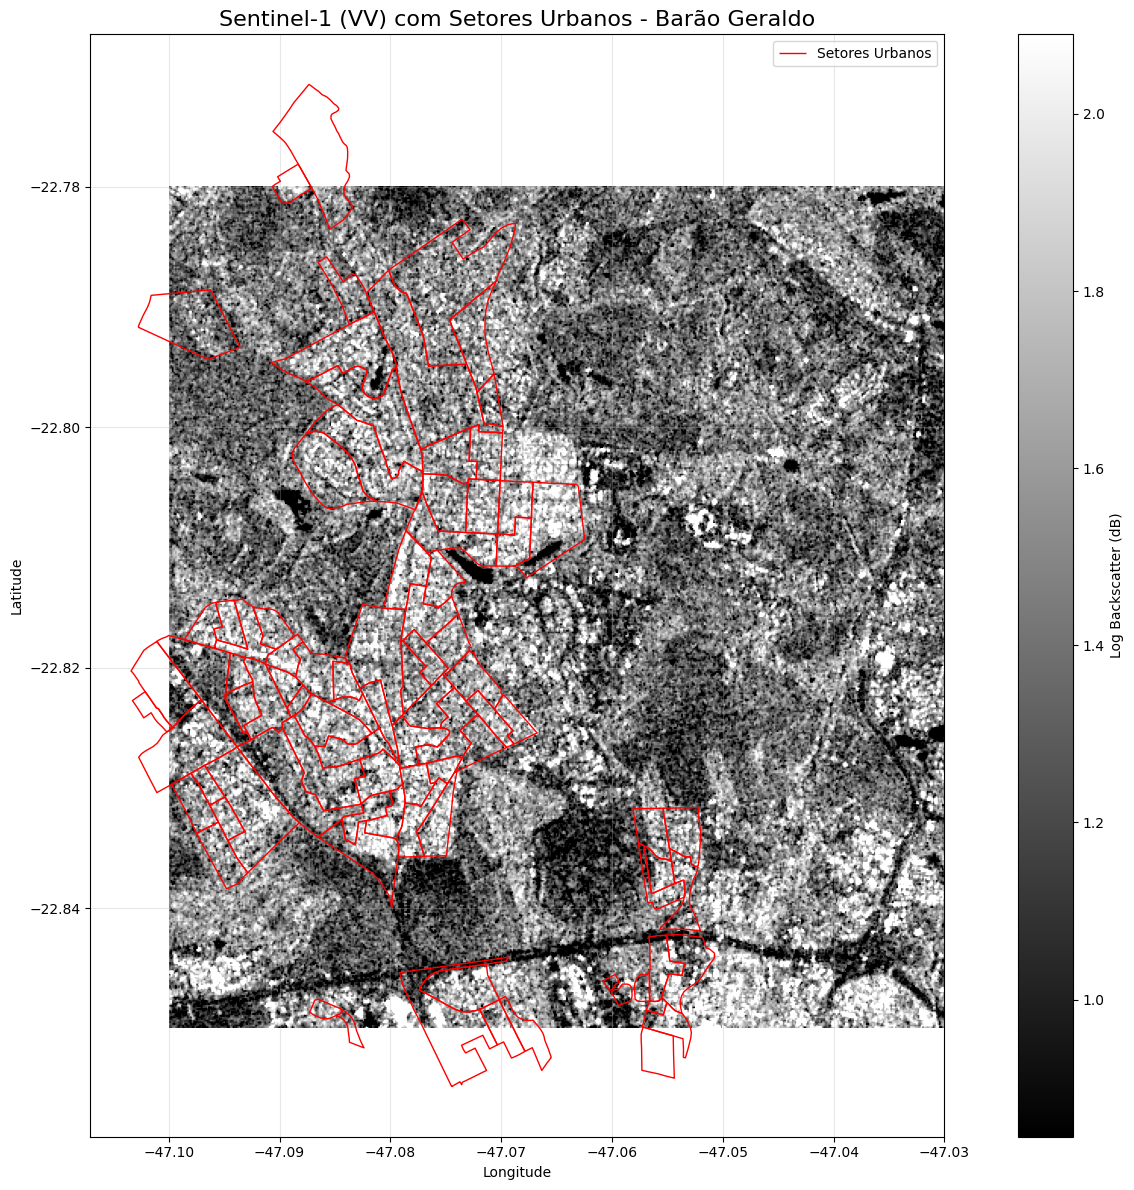

✓ Visualização salva em data/processed/s1_sectors_validation.png

--- Validando setores Sentinel-2 ---
  CRS da imagem: EPSG:4326
  Bounds da imagem: BoundingBox(left=-47.1, bottom=-22.85, right=-47.03, top=-22.78)
  Dimensões: 512 x 512
  Bandas: 4
  Visualizando Sentinel-2 como RGB


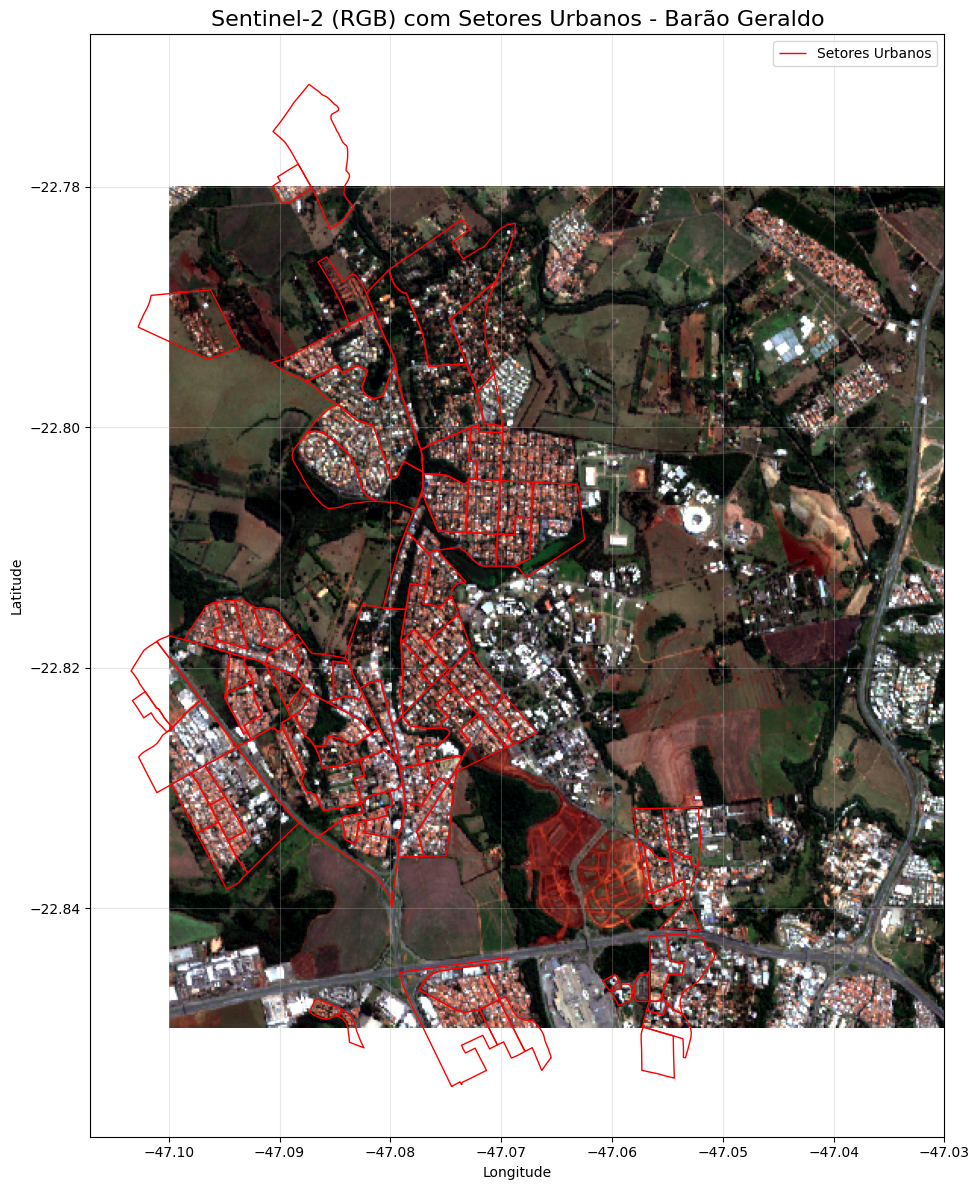

✓ Visualização salva em data/processed/s2_sectors_validation.png

✅ Resultados da validação de setores:
  Sentinel-1: ✓
  Sentinel-2: ✓


In [39]:
def validate_sectors_coverage(tiff_path, gdf, title, output_file):
    """Visualiza a imagem com contornos dos setores censitários."""
    if not os.path.exists(tiff_path):
        print(f'❌ Arquivo {tiff_path} não encontrado')
        return False
    try:
        with rasterio.open(tiff_path) as src:
            print(f'  CRS da imagem: {src.crs}')
            print(f'  Bounds da imagem: {src.bounds}')
            print(f'  Dimensões: {src.width} x {src.height}')
            print(f'  Bandas: {src.count}')
            gdf_reproj = gdf.to_crs(src.crs)
            image = src.read()
            fig, ax = plt.subplots(figsize=(15, 12))
            if image.shape[0] >= 3:
                rgb = image[[0, 1, 2]]
                rgb_norm = np.zeros_like(rgb, dtype=np.float32)
                for i in range(3):
                    band = rgb[i]
                    p2, p98 = np.percentile(band[band > 0], [2, 98])
                    rgb_norm[i] = np.clip((band - p2) / (p98 - p2), 0, 1)
                img_display = rgb_norm.transpose(1, 2, 0)
                ax.imshow(img_display, extent=[src.bounds.left, src.bounds.right, 
                                              src.bounds.bottom, src.bounds.top])
                print('  Visualizando Sentinel-2 como RGB')
            else:
                band = image[0]
                band_log = np.log10(band + 1e-10)
                vmin, vmax = np.percentile(band_log[band_log > -10], [5, 95])
                im = ax.imshow(band_log, cmap='gray', vmin=vmin, vmax=vmax,
                              extent=[src.bounds.left, src.bounds.right, 
                                      src.bounds.bottom, src.bounds.top])
                plt.colorbar(im, ax=ax, label='Log Backscatter (dB)')
                print('  Visualizando Sentinel-1 (VV) em escala log')
            gdf_reproj.boundary.plot(ax=ax, color='red', linewidth=1, label='Setores Urbanos')
            ax.set_title(title, fontsize=16)
            ax.set_xlabel('Longitude' if src.crs.to_string() == 'EPSG:4326' else 'X (m)')
            ax.set_ylabel('Latitude' if src.crs.to_string() == 'EPSG:4326' else 'Y (m)')
            ax.legend()
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            plt.show()
            print(f'✓ Visualização salva em {output_file}')
            return True
    except Exception as e:
        print(f'❌ Erro na validação dos setores para {tiff_path}: {e}')
        import traceback
        traceback.print_exc()
        return False

if sectors_gdf_urban is not None:
    print('\n--- Validando setores Sentinel-1 ---')
    s1_sectors_ok = validate_sectors_coverage(s1_path, sectors_gdf_urban, 
                                             'Sentinel-1 (VV) com Setores Urbanos - Barão Geraldo', 
                                             'data/processed/s1_sectors_validation.png')
    print('\n--- Validando setores Sentinel-2 ---')
    s2_sectors_ok = validate_sectors_coverage(s2_path, sectors_gdf_urban, 
                                             'Sentinel-2 (RGB) com Setores Urbanos - Barão Geraldo', 
                                             'data/processed/s2_sectors_validation.png')
    print(f'\n✅ Resultados da validação de setores:')
    print(f'  Sentinel-1: {"✓" if s1_sectors_ok else "❌"}')
    print(f'  Sentinel-2: {"✓" if s2_sectors_ok else "❌"}')

## 4. Recorte das Imagens por Setor Censitário

Recortamos as imagens Sentinel-1 e Sentinel-2 para cada setor censitário urbano, salvando em `data/processed/`. Setores fora da área do raster são ignorados.

In [40]:
def clip_image_by_sector(tiff_path, gdf, output_prefix):
    """Recorta a imagem TIFF por setores censitários."""
    if not os.path.exists(tiff_path):
        print(f'❌ Arquivo {tiff_path} não encontrado. Execute ingest_sentinel.ipynb para gerar o arquivo.')
        return 0
    if gdf is None:
        print(f'❌ GeoDataFrame inválido. Verifique o carregamento de {sectors_path}.')
        return 0
    clipped_count = 0
    skipped_count = 0
    try:
        with rasterio.open(tiff_path) as src:
            print(f'✓ TIFF aberto: {tiff_path}, CRS: {src.crs}, Bandas: {src.count}, Bounds: {src.bounds}')
            # Reprojetar GeoDataFrame para o CRS da imagem
            gdf_reproj = gdf.to_crs(src.crs)
            for idx, sector in gdf_reproj.iterrows():
                try:
                    cd_setor = sector['CD_SETOR']
                except KeyError as e:
                    print(f'❌ Erro: Coluna CD_SETOR não encontrada no GeoDataFrame. Colunas disponíveis: {list(gdf.columns)}')
                    return 0
                geom = [sector.geometry]
                try:
                    out_image, out_transform = mask(src, geom, crop=True, nodata=0)
                    if out_image.max() == 0:
                        print(f'⚠️ Setor {cd_setor} não contém dados válidos')
                        skipped_count += 1
                        continue
                    out_meta = src.meta.copy()
                    out_meta.update({
                        'height': out_image.shape[1],
                        'width': out_image.shape[2],
                        'transform': out_transform,
                        'nodata': 0
                    })
                    output_file = f'data/processed/{output_prefix}_setor_{cd_setor}.tiff'
                    with rasterio.open(output_file, 'w', **out_meta) as dst:
                        dst.write(out_image)
                    clipped_count += 1
                    print(f'✓ Recortado: {output_file} ({os.path.getsize(output_file) / (1024 * 1024):.2f} MB)')
                except ValueError as e:
                    if 'Input shapes do not overlap raster' in str(e):
                        print(f'⚠️ Setor {cd_setor} fora da área do raster, pulando')
                        skipped_count += 1
                        continue
                    else:
                        print(f'❌ Erro ao recortar setor {cd_setor}: {e}')
                        import traceback
                        traceback.print_exc()
                except Exception as e:
                    print(f'❌ Erro ao recortar setor {cd_setor}: {e}')
                    import traceback
                    traceback.print_exc()
        print(f'✓ Total de setores recortados ({output_prefix}): {clipped_count}')
        print(f'⚠️ Total de setores pulados ({output_prefix}): {skipped_count}')
        return clipped_count
    except Exception as e:
        print(f'❌ Erro ao abrir {tiff_path}: {e}')
        import traceback
        traceback.print_exc()
        return 0

if sectors_gdf_urban is not None and s1_ok and s2_ok:
    print('\n--- Recortando Sentinel-1 por setores ---')
    s1_clipped = clip_image_by_sector(s1_path, sectors_gdf_urban, 's1')
    print('\n--- Recortando Sentinel-2 por setores ---')
    s2_clipped = clip_image_by_sector(s2_path, sectors_gdf_urban, 's2')
else:
    print('❌ Pulando recorte devido a falhas na validação')


--- Recortando Sentinel-1 por setores ---
✓ TIFF aberto: data/sentinel1_unicamp.tiff, CRS: EPSG:4326, Bandas: 2, Bounds: BoundingBox(left=-47.1, bottom=-22.85, right=-47.03, top=-22.78)
✓ Recortado: data/processed/s1_setor_350950210000001.tiff (0.00 MB)
✓ Recortado: data/processed/s1_setor_350950210000002.tiff (0.00 MB)
✓ Recortado: data/processed/s1_setor_350950210000003.tiff (0.00 MB)
✓ Recortado: data/processed/s1_setor_350950210000005.tiff (0.01 MB)
✓ Recortado: data/processed/s1_setor_350950210000006.tiff (0.01 MB)
✓ Recortado: data/processed/s1_setor_350950210000007.tiff (0.00 MB)
✓ Recortado: data/processed/s1_setor_350950210000017.tiff (0.00 MB)
✓ Recortado: data/processed/s1_setor_350950210000021.tiff (0.01 MB)
✓ Recortado: data/processed/s1_setor_350950210000024.tiff (0.00 MB)
✓ Recortado: data/processed/s1_setor_350950210000030.tiff (0.01 MB)
✓ Recortado: data/processed/s1_setor_350950210000037.tiff (0.01 MB)
✓ Recortado: data/processed/s1_setor_350950210000038.tiff (0.02 M

## 5. Resumo da Execução

Resumimos o status da validação e pré-processamento.

In [41]:
print('\n' + '='*50)
print('📋 RESUMO DA EXECUÇÃO')
print('='*50)
print(f'✓ Bounding box validada: {"Sim" if bbox_gdf is not None else "Não"}')
print(f'✓ Setores urbanos processados: {len(sectors_gdf_urban) if sectors_gdf_urban is not None else 0}')
print(f'✓ Validação Sentinel-1 (bbox): {"✓" if s1_ok else "❌"}')
print(f'✓ Validação Sentinel-2 (bbox): {"✓" if s2_ok else "❌"}')
print(f'✓ Validação Sentinel-1 (setores): {"✓" if s1_sectors_ok else "❌"}')
print(f'✓ Validação Sentinel-2 (setores): {"✓" if s2_sectors_ok else "❌"}')
print(f'✓ Imagens Sentinel-1 recortadas: {s1_clipped if "s1_clipped" in locals() else 0}')
print(f'✓ Imagens Sentinel-2 recortadas: {s2_clipped if "s2_clipped" in locals() else 0}')

print('\n🗂️ ARQUIVOS GERADOS:')
for file in glob.glob('data/processed/*.tiff') + glob.glob('data/processed/*.png'):
    if os.path.exists(file):
        print(f'  ✓ {file} (Tamanho: {os.path.getsize(file) / 1024 / 1024:.2f} MB)')


📋 RESUMO DA EXECUÇÃO
✓ Bounding box validada: Sim
✓ Setores urbanos processados: 88
✓ Validação Sentinel-1 (bbox): ✓
✓ Validação Sentinel-2 (bbox): ✓
✓ Validação Sentinel-1 (setores): ✓
✓ Validação Sentinel-2 (setores): ✓
✓ Imagens Sentinel-1 recortadas: 88
✓ Imagens Sentinel-2 recortadas: 88

🗂️ ARQUIVOS GERADOS:
  ✓ data/processed/s1_setor_350950210000088.tiff (Tamanho: 0.00 MB)
  ✓ data/processed/s2_setor_350950210000137.tiff (Tamanho: 0.00 MB)
  ✓ data/processed/s2_setor_350950210000089.tiff (Tamanho: 0.00 MB)
  ✓ data/processed/s2_setor_350950210000102.tiff (Tamanho: 0.01 MB)
  ✓ data/processed/s2_setor_350950210000002.tiff (Tamanho: 0.01 MB)
  ✓ data/processed/s1_setor_350950210000165.tiff (Tamanho: 0.00 MB)
  ✓ data/processed/s1_setor_350950210000159.tiff (Tamanho: 0.00 MB)
  ✓ data/processed/s2_setor_350950210000066.tiff (Tamanho: 0.00 MB)
  ✓ data/processed/s2_setor_350950210000115.tiff (Tamanho: 0.00 MB)
  ✓ data/processed/s1_setor_350950210000143.tiff (Tamanho: 0.00 MB)
  ✓